## 1. Load and prepare data

In [26]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn import preprocessing

%matplotlib inline

In [6]:
australia = pd.read_csv('weatherAUS.csv')
australia = australia.drop(['Location','Date','Evaporation','Sunshine', 'Cloud9am','Cloud3pm',
                           'WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm','WindSpeed9am',
                           'WindSpeed3pm'], axis=1)

In [7]:
Y = australia.RainTomorrow
X = australia.drop(['RainTomorrow'], axis=1)

In [8]:
X = X.replace({'No':0, 'Yes':1})
X = X.fillna(0)
Y = Y.replace({'No':0, 'Yes':1})
Y = Y.fillna(0)

### 1.2 Scaling data

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()

In [10]:
X_scaled = pd.DataFrame(min_max_scaler.fit_transform(X), columns = X.columns)

In [11]:
X_scaled.head()

,MinTemp,MaxTemp,Rainfall,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM
0,0.516509,0.523629,0.001617,0.71,0.22,0.968012,0.968738,0.508439,0.522073,0.0,0.000000
1,0.375000,0.565217,0.000000,0.44,0.25,0.970797,0.969411,0.514768,0.570058,0.0,0.000000
2,0.504717,0.576560,0.000000,0.38,0.30,0.967915,0.970277,0.594937,0.548944,0.0,0.000000
3,0.417453,0.620038,0.000000,0.45,0.16,0.977522,0.974221,0.533755,0.612284,0.0,0.002695
4,0.613208,0.701323,0.002695,0.82,0.33,0.970989,0.967680,0.527426,0.673704,0.0,0.000539


### 1.3 Splitting data

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.25, random_state=43)

## 2. Univariate feature selection

In [13]:
select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)

In [14]:
for i in select_feature.scores_:
    print(i)

#print('Score list: %0.5f' % select_feature.scores_)
print('Feature list:', x_train.columns)
# RISK_MM, RainToday, Humidity3pm, Rainfall, Humidity9am

37.9499074448
78.2959836888
484.218282184
372.326875069
1722.84683223
0.415402720613
0.387219341582
1.90608879304
128.201224658
7864.23639993
2253.21804011
Feature list: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RISK_MM'],
      dtype='object')


### 2.1 Choosing the best k values

In [15]:
x_train_k_best = select_feature.transform(x_train)
x_test_k_best = select_feature.transform(x_test)

In [16]:
x_train.shape

(109095, 11)

In [17]:
x_train_k_best.shape

(109095, 5)

### 2.2 Testing with Random Forest

In [18]:
RandForest_K_best = RandomForestClassifier()      
RandForest_K_best = RandForest_K_best.fit(x_train_k_best,y_train)

In [19]:
y_pred = RandForest_K_best.predict(x_test_k_best)
accuracy = accuracy_score(y_test, y_pred)

In [20]:
print('Accuracy: ',accuracy)

Accuracy:  1.0


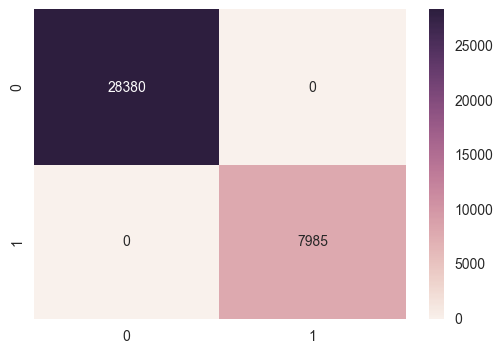

In [21]:
confMatrix = confusion_matrix(y_test, y_pred)
sb.heatmap(confMatrix, annot=True, fmt="d")

## 3. Recursive Feature Elimination

In [23]:
RandForest_RFE = RandomForestClassifier() 
rfe = RFE(estimator=RandForest_RFE, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train, y_train)

In [24]:
print('Chosen best 5 feature by rfe:',x_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['Rainfall', 'Humidity3pm', 'Pressure3pm', 'RainToday', 'RISK_MM'], dtype='object')


## 4. Recursive Feature Elimination with Cross-Validation

In [28]:
RandForest_RFECV = RandomForestClassifier() 
rfecv = RFECV(estimator=RandForest_RFECV, step=1, cv=5, scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 5
Best features : Index(['Rainfall', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'RISK_MM'], dtype='object')


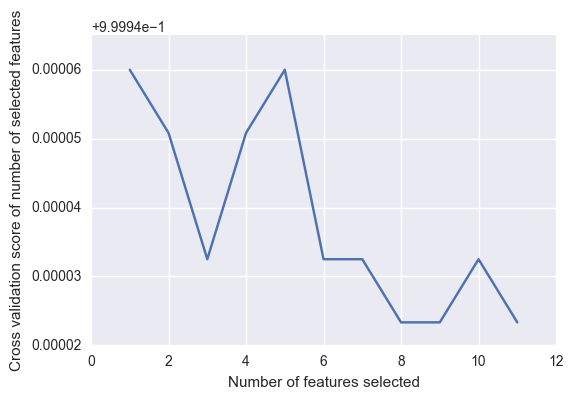

In [29]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## 5. Tree based feature selection

In [30]:
RandForest_Tree = RandomForestClassifier()      
RandForest_Tree = RandForest_Tree.fit(x_train, y_train)
importances = RandForest_Tree.feature_importances_
std = np.std([tree.feature_importances_ for tree in RandForest_Tree.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [31]:
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 10 (0.794031)
2. feature 4 (0.093987)
3. feature 9 (0.030503)
4. feature 2 (0.028798)
5. feature 3 (0.012908)
6. feature 6 (0.012340)
7. feature 5 (0.010542)
8. feature 8 (0.004720)
9. feature 0 (0.004242)
10. feature 7 (0.004077)
11. feature 1 (0.003852)


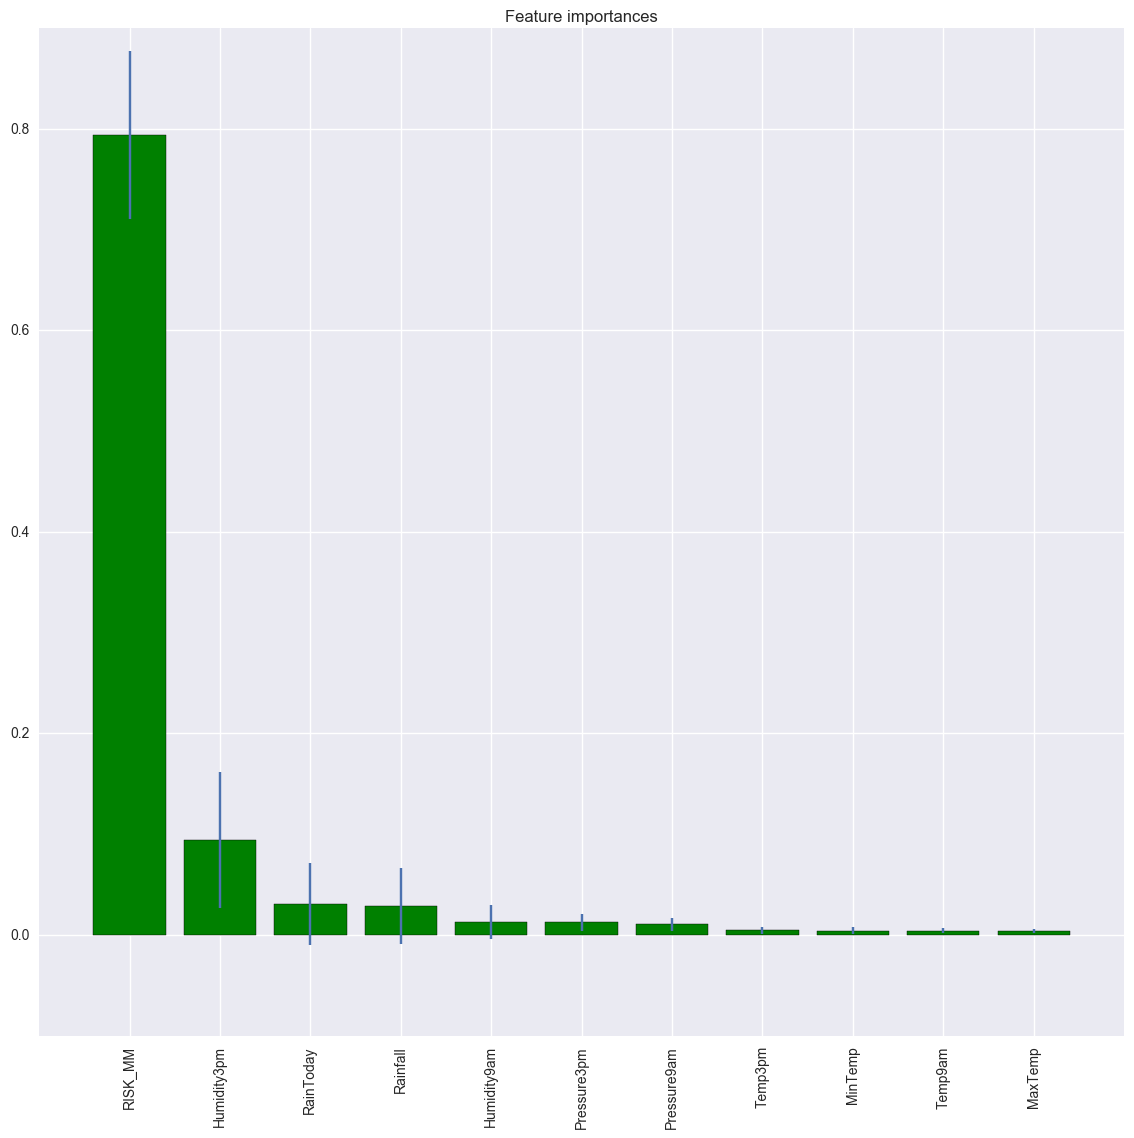

In [32]:
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()